In [1]:
from dataset import NiiFolder
from transforms import RandomHorizontalFlip2D 

import torch 
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, datasets

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import copy
import random

## Гиперпараметры

In [2]:
in_channels = 60
num_classes = 2
epochs = 10
lr = 0.001
batch_size = 10
beta1 = 0.5

ngpu = 2
dataroot = "/data/metastasises-ws/data/metastasises_dataset/train2D/"
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

## Сеть с архитектурой позаимствованной у AlexNet

In [3]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=num_classes):
        
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(60, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

Цикл тренировки:

In [4]:
def valid(model, dataloader, criterion):
    model.eval()
    loss = 0.0
    corrects = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data[0].float().to(device), data[1].to(device)
        y_pred = model(inputs)
        _, predicted = torch.max(y_pred.data, 1)
        corrects += torch.sum(predicted == labels.data).item()
        loss += criterion(y_pred, labels)
        
    model.train()    
    return loss.item()/len(dataloader.dataset), corrects/len(dataloader.dataset)

def train(model, dataloader, optimizer, val_dataloader = None, criterion = nn.CrossEntropyLoss(), epochs = 20, device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")):
    model.train()
    losses = []
    val_losses = []
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_corrects = 0.0

        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0].float().to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_corrects += torch.sum(predicted == labels.data).item()
#             print( running_corrects.item())

            running_loss += loss.item()
            losses.append(loss.item()/batch_size)
            
            if val_dataloader: 
                val_loss, val_corr = valid(model, val_dataloader, criterion)
                val_losses.append(val_loss)
                
        val_loss, val_corr = valid(model, val_dataloader, criterion)        
        print('[epoch %d] loss: %.3f, correct: %.3f, val_loss: %.3f, val_corr: %.3f' % (epoch+1, running_loss/len(dataloader.dataset), running_corrects/len(dataloader.dataset), val_loss, val_corr))
        

    print('Finished Training')
    if val_dataloader: return losses, val_losses
    return losses

Подготовка датасета и трансформаций

In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.shape).numpy() * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
nii_transforms = transforms.Compose([
#     transforms.RandomVerticalFlip(), не работает
#     transforms.RandomResizedCrop(256, scale=(5.0, 10.0)), не работает
    RandomHorizontalFlip2D(),
    AddGaussianNoise()
#     transforms.ToTensor()
])

full_dataset =  NiiFolder(dataroot, transform = nii_transforms)

train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])



train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

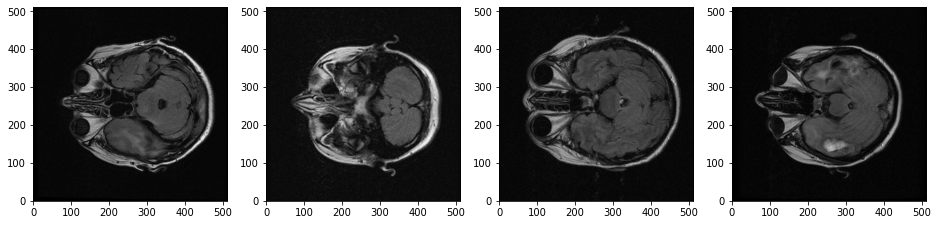

In [6]:
model = AlexNet().to(device)
x = next(iter(train_loader))[0].to(device=device, dtype=torch.float)
y = model(x)
fig, axes = plt.subplots(1, 4, figsize=(16,4), squeeze=False)
for i in range(4):
        axes[0][i].imshow(x[i,5,:,:].cpu() , cmap="gray", origin="lower")

Тренировка и результаты

In [9]:
model = AlexNet().to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)


# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
# criterion = nn.MSELoss()

losses, val_losses = train(model, train_loader, optimizer, device = device, val_dataloader = test_loader, epochs = 30)

[epoch 1] loss: 0.426, correct: 0.347, val_loss: 0.403, val_corr: 0.333
[epoch 2] loss: 0.092, correct: 0.653, val_loss: 0.106, val_corr: 0.667
[epoch 3] loss: 0.071, correct: 0.490, val_loss: 0.122, val_corr: 0.333
[epoch 4] loss: 0.070, correct: 0.592, val_loss: 0.150, val_corr: 0.333
[epoch 5] loss: 0.073, correct: 0.592, val_loss: 0.127, val_corr: 0.333
[epoch 6] loss: 0.075, correct: 0.633, val_loss: 0.131, val_corr: 0.333
[epoch 7] loss: 0.069, correct: 0.653, val_loss: 0.123, val_corr: 0.333
[epoch 8] loss: 0.068, correct: 0.673, val_loss: 0.134, val_corr: 0.333
[epoch 9] loss: 0.068, correct: 0.653, val_loss: 0.145, val_corr: 0.333
[epoch 10] loss: 0.067, correct: 0.673, val_loss: 0.142, val_corr: 0.333
[epoch 11] loss: 0.068, correct: 0.673, val_loss: 0.127, val_corr: 0.333
[epoch 12] loss: 0.065, correct: 0.673, val_loss: 0.123, val_corr: 0.333
[epoch 13] loss: 0.065, correct: 0.694, val_loss: 0.098, val_corr: 0.833
[epoch 14] loss: 0.066, correct: 0.714, val_loss: 0.122, val

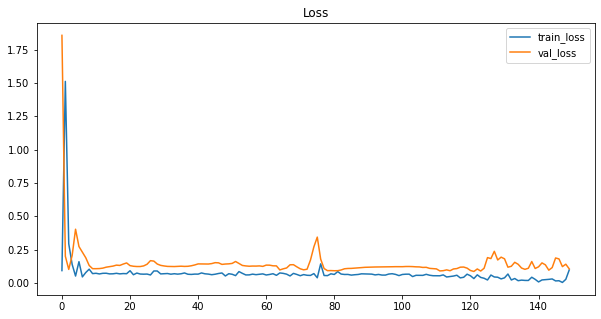

In [12]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(losses,label="train_loss")
plt.plot(val_losses,label="val_loss")
plt.legend()
plt.show()

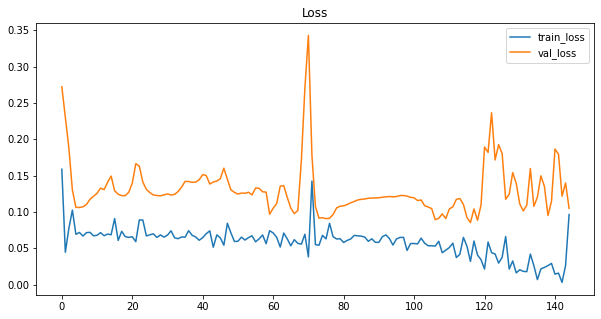

In [13]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(losses[5:],label="train_loss")
plt.plot(val_losses[5:],label="val_loss")
plt.legend()
plt.show()

In [11]:
torch.save(model.state_dict(),"./models/AlexNet2D_30eph.pth")

Так как у нас очень маленький датасет, попробовали делать k-fold (с рандомным выбором), чисто что бы посмотреть графичек

In [9]:
#random fold
full_dataset =  NiiFolder(dataroot)
losses = []
val_losses = []
for i in range(5):
    print("--- Start of random-fold", i,"---")
    train_size = int(0.9 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    aNet = AlexNet().to(device)
#     aNet.load_state_dict(model.state_dict()) 
    optimizer = optim.Adam(aNet.parameters(), lr = 1e-4)

    loss, val_loss = train(aNet, train_loader, optimizer, device = device, val_dataloader = test_loader, epochs = 10)
    losses.append(loss)
    val_losses.append(val_loss)
    

--- Start of random-fold 0 ---
[epoch 1] loss: 0.210, correct: 0.612, val_loss: 0.285, val_corr: 0.167
[epoch 2] loss: 0.082, correct: 0.408, val_loss: 0.119, val_corr: 0.167
[epoch 3] loss: 0.071, correct: 0.531, val_loss: 0.113, val_corr: 0.833
[epoch 4] loss: 0.071, correct: 0.592, val_loss: 0.112, val_corr: 0.833
[epoch 5] loss: 0.070, correct: 0.592, val_loss: 0.111, val_corr: 0.833
[epoch 6] loss: 0.070, correct: 0.592, val_loss: 0.109, val_corr: 0.833
[epoch 7] loss: 0.069, correct: 0.612, val_loss: 0.104, val_corr: 0.833
[epoch 8] loss: 0.067, correct: 0.633, val_loss: 0.097, val_corr: 0.833
[epoch 9] loss: 0.063, correct: 0.653, val_loss: 0.090, val_corr: 1.000
[epoch 10] loss: 0.060, correct: 0.633, val_loss: 0.104, val_corr: 0.500
Finished Training
--- Start of random-fold 1 ---
[epoch 1] loss: 0.365, correct: 0.449, val_loss: 0.117, val_corr: 0.667
[epoch 2] loss: 0.096, correct: 0.571, val_loss: 0.122, val_corr: 0.333
[epoch 3] loss: 0.072, correct: 0.592, val_loss: 0.117,

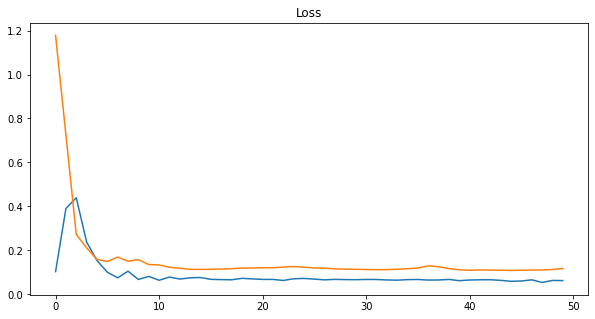

In [11]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(np.mean(losses, axis = 0),label="train_loss")
plt.plot(np.mean(val_losses, axis = 0),label="val_loss")